# Example: N-body simulation

Here we provide a simple example of an N-body integrator implemented using force and potential evaluation routines from pytreegrav. If you were writing a more serious simulation code you would want to adopt a more modular, object-oriented approach, but this suffices to demonstrate the use of pytreegrav.

## Initial Conditions
We first make a function to initialize some particles in a Gaussian blob. You can try modifying the IC generator and playing around with the initial velocity and geometry for extra fun. We also write a function to evaluate the total energy, which is conserved down to tree-force and integration errors.

In [1]:
%pylab
from pytreegrav import Accel, Potential


def GenerateICs(N, seed=42):
    np.random.seed(seed)  # seed the RNG for reproducibility
    pos = np.random.normal(size=(N, 3))  # positions of particles
    pos -= np.average(pos, axis=0)  # put center of mass at the origin
    vel = np.zeros_like(pos)  # initialize at rest
    vel -= np.average(vel, axis=0)  # make average velocity 0
    softening = np.repeat(0.1, N)  # initialize softening to 0.1
    masses = np.repeat(1.0 / N, N)  # make the system have unit mass
    return pos, masses, vel, softening


def TotalEnergy(pos, masses, vel, softening):
    kinetic = 0.5 * np.sum(masses[:, None] * vel**2)
    potential = 0.5 * np.sum(masses * Potential(pos, masses, softening, parallel=True))
    return kinetic + potential

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Stepper function
Now let's define the basic timestep for a leapfrog integrator, put in the Hamiltonian split kick-drift-kick form (e.g. Springel 2005).

In [2]:
def leapfrog_kdk_timestep(dt, pos, masses, softening, vel, accel):
    # first a half-step kick
    vel[:] = vel + 0.5 * dt * accel  # note that you must slice arrays to modify them in place in the function!
    # then full-step drift
    pos[:] = pos + dt * vel
    # then recompute accelerations
    accel[:] = Accel(pos, masses, softening, parallel=True)
    # then another half-step kick
    vel[:] = vel + 0.5 * dt * accel

## Main simulation loop

In [3]:
pos, masses, vel, softening = GenerateICs(10000)  # initialize initial condition with 10k particles

accel = Accel(pos, masses, softening, parallel=True)  # initialize acceleration

t = 0  # initial time
Tmax = 50  # final/max time

energies = []  # energies
r50s = []  # half-mass radii
ts = []  # times


while t <= Tmax:  # actual simulation loop - this may take a couple minutes to run
    r50s.append(np.median(np.sum((pos - np.median(pos, axis=0)) ** 2, axis=1) ** 0.5))
    energies.append(TotalEnergy(pos, masses, vel, softening))
    ts.append(t)

    dt = 0.03  # adjust this to control integration error

    leapfrog_kdk_timestep(dt, pos, masses, softening, vel, accel)
    t += dt

print("Simulation complete! Relative energy error: %g" % (np.abs((energies[0] - energies[-1]) / energies[0])))

Simulation complete! Relative energy error: 0.00161328


## Analysis
Now we can plot the half-mass radius (to get an idea of how the system pulsates over time) and the total energy (to check for accuracy) as a function of time

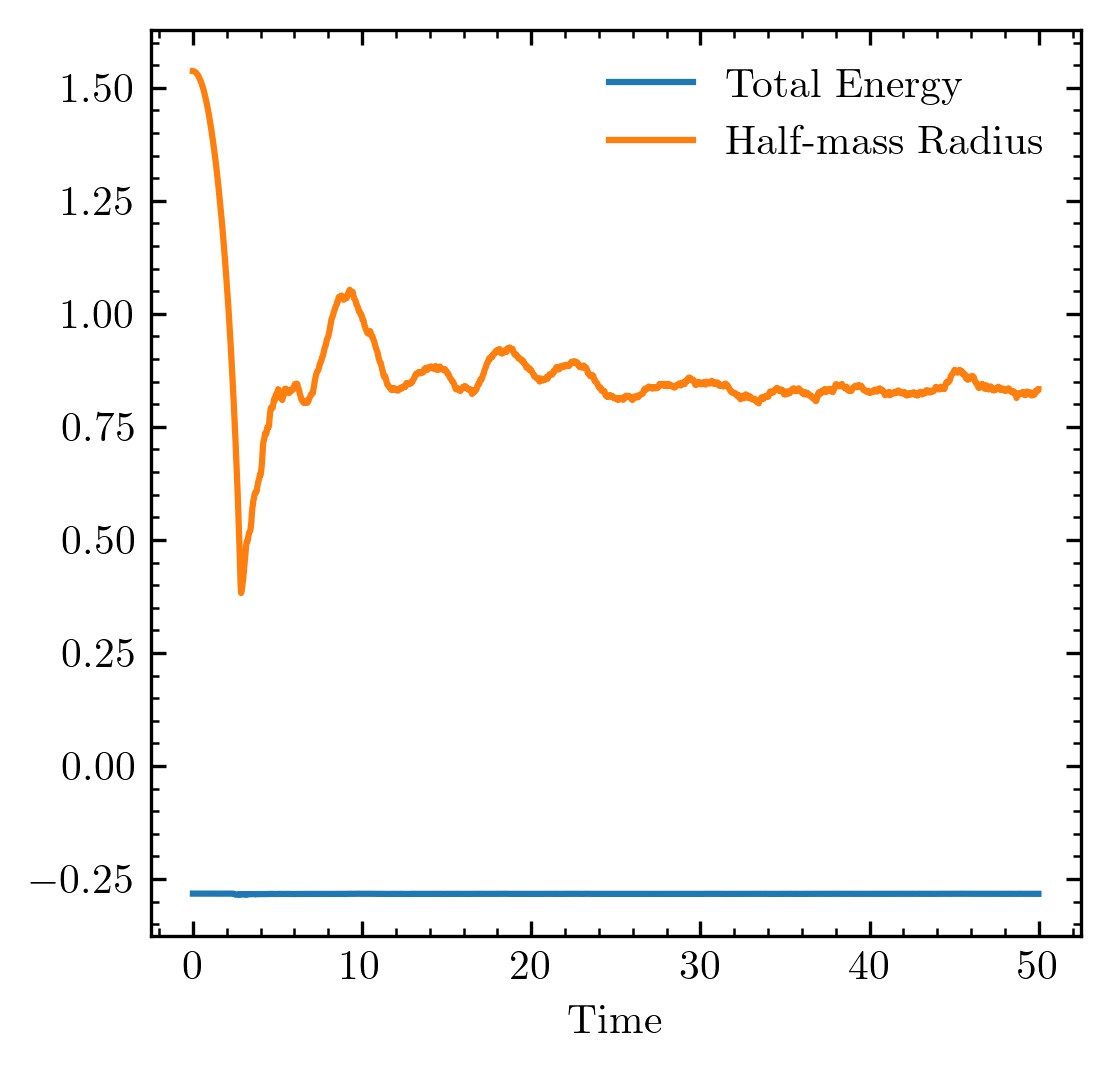

In [4]:
%matplotlib inline
plt.figure(figsize=(4, 4), dpi=300)
plt.plot(ts, energies, label="Total Energy")
plt.plot(ts, r50s, label="Half-mass Radius")
plt.xlabel("Time")
plt.legend()